<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/Homework03_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

2022-11-19 16:43:49.926852: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-19 16:43:49.991496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 16:43:49.991506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/lotta/anaconda3/envs/wtf-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualization function
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    plt.figure()
    line1 , = plt.plot(train_losses , "b-")
    line2 , = plt.plot(test_losses , "r-") 
    line3 , = plt.plot(train_accuracies , "b:")
    line4 , = plt.plot(test_accuracies , "r:") 
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

In [3]:
# Prepare the data
def prepare_mnist_data(mnist_data, batch_size):
    mnist_data = mnist_data.map(lambda image, target: (tf.cast(image, tf.float32) / 128. - 1, target))
    mnist_data = mnist_data.map(lambda image, target: (tf.reshape(image, (-1,)), target))
    mnist_data = mnist_data.map(lambda image, target: (image, tf.one_hot(target, 10)))
    mnist_data.cache()
    mnist_data = mnist_data.shuffle(1000)
    mnist_data = mnist_data.batch(batch_size)
    mnist_data = mnist_data.prefetch(tf.data.AUTOTUNE)
    return mnist_data

In [4]:
class MyModel(tf.keras.Model):
    # Define the layers of the model
    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # Forward pass
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [5]:
# Define the training step
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(input)
        loss = loss_function(target, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, predictions

# Define the test step
def test_step(model, image, target, loss_function):
    predictions = model(image)
    loss = loss_function(target, predictions)
    return loss, predictions

In [6]:
# Test the model
def test(model, test_ds, loss_function):
    losses = []
    accuracy_aggregator = []
    for image, target in test_ds:
        loss, predictions = test_step(model, image, target, loss_function)
        losses.append(loss)
        accuracy_aggregator.append(np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1)))
    return tf.reduce_mean(losses), tf.reduce_mean(accuracy_aggregator)

In [7]:
# Define the complete training function
def train(model, train_ds, test_ds, epochs, loss_function, optimizer, train_losses, train_accuracies, test_losses, test_accuracies):

    # Estimate the loss and accuracy on the train set before training
    loss, accuracy = test(model, train_ds, loss_function)
    train_losses.append(loss)       
    train_accuracies.append(accuracy)

    # Estimate the loss and accuracy on the test set before training
    loss, accuracy = test(model, test_ds, loss_function)
    test_losses.append(loss)      
    test_accuracies.append(accuracy)

    print("Pretraining, Loss: {}, Accuracy: {}, (Train)".format(train_losses[-1], train_accuracies[-1])) 
    print("Pretraining, Loss: {}, Accuracy: {}, (Test)".format(test_losses[-1], test_accuracies[-1])) 
    
    # Train the model
    for epoch in range(epochs):
        train_accuracy_aggregator = []
        losses = []
        for image, target in train_ds:
            loss, predictions = train_step(model, image, target, loss_function, optimizer)
            losses.append(loss)
            train_accuracy_aggregator.append(np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1)))

        # Estimate the loss and accuracy on the train set after training    
        train_losses.append(tf.reduce_mean(losses))
        train_accuracies.append(tf.reduce_mean(train_accuracy_aggregator))

        # Estimate the loss and accuracy on the test set after each epoch
        loss, accuracy = test(model, train_ds, loss_function)
        test_losses.append(loss)         
        test_accuracies.append(accuracy)

        print("Epoch: {}, Loss: {}, Accuracy: {}, (Train)".format(epoch + 1, train_losses[-1], train_accuracies[-1])) 
        print("Epoch: {}, Loss: {}, Accuracy: {}, (Test)".format(epoch + 1, test_losses[-1], test_accuracies[-1])) 

    return train_losses, train_accuracies, test_losses, test_accuracies

In [21]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

Pretraining, Loss: 3.310187578201294, Accuracy: 0.07146666666666666, (Train)
Pretraining, Loss: 3.318235397338867, Accuracy: 0.07088658146964856, (Test)
Epoch: 1, Loss: 0.3598880171775818, Accuracy: 0.8905833333333333, (Train)
Epoch: 1, Loss: 0.148999884724617, Accuracy: 0.95495, (Test)
Epoch: 2, Loss: 0.15874242782592773, Accuracy: 0.95145, (Train)
Epoch: 2, Loss: 0.12922750413417816, Accuracy: 0.9606833333333333, (Test)
Epoch: 3, Loss: 0.12483928352594376, Accuracy: 0.9613666666666667, (Train)
Epoch: 3, Loss: 0.0936378762125969, Accuracy: 0.9709833333333333, (Test)
Epoch: 4, Loss: 0.1040295884013176, Accuracy: 0.9681833333333333, (Train)
Epoch: 4, Loss: 0.08079162240028381, Accuracy: 0.97465, (Test)
Epoch: 5, Loss: 0.09055580943822861, Accuracy: 0.9721666666666666, (Train)
Epoch: 5, Loss: 0.0668354332447052, Accuracy: 0.9791166666666666, (Test)
Epoch: 6, Loss: 0.07782989740371704, Accuracy: 0.9753833333333334, (Train)
Epoch: 6, Loss: 0.09057514369487762, Accuracy: 0.97165, (Test)
Epo

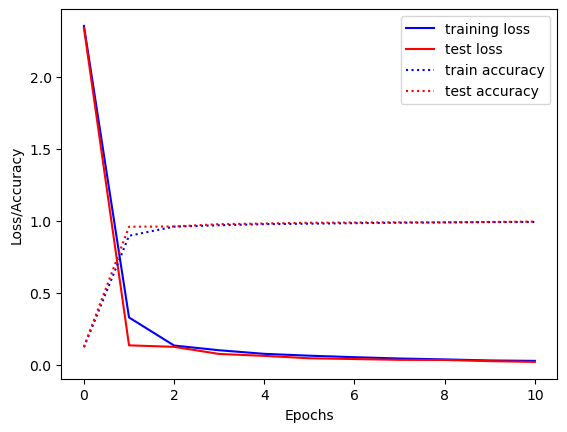

In [9]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## ADJUSTING HYPERPARAMETERS

Observation is done by changing only one particular parameter, and having the remaining parameters the same as followings:

```
learning_rate = 0.1
n_unit = 256
batch_size = 32
```



### 1) Reducing layer size from 256 to 32 neurons

Pretraining, Loss: 2.785047769546509, Accuracy: 0.09906666666666666, (Train)
Pretraining, Loss: 2.7797605991363525, Accuracy: 0.09774361022364217, (Test)
Epoch: 1, Loss: 0.47932422161102295, Accuracy: 0.8455, (Train)
Epoch: 1, Loss: 0.250277578830719, Accuracy: 0.92055, (Test)
Epoch: 2, Loss: 0.2515581548213959, Accuracy: 0.9228166666666666, (Train)
Epoch: 2, Loss: 0.20404598116874695, Accuracy: 0.93865, (Test)
Epoch: 3, Loss: 0.21433107554912567, Accuracy: 0.9336833333333333, (Train)
Epoch: 3, Loss: 0.16663406789302826, Accuracy: 0.9484, (Test)
Epoch: 4, Loss: 0.19524015486240387, Accuracy: 0.9417, (Train)
Epoch: 4, Loss: 0.17710456252098083, Accuracy: 0.9445166666666667, (Test)
Epoch: 5, Loss: 0.18026186525821686, Accuracy: 0.9450833333333334, (Train)
Epoch: 5, Loss: 0.15021592378616333, Accuracy: 0.9536666666666667, (Test)
Epoch: 6, Loss: 0.1729167252779007, Accuracy: 0.9477833333333333, (Train)
Epoch: 6, Loss: 0.1419357806444168, Accuracy: 0.95615, (Test)
Epoch: 7, Loss: 0.16244384

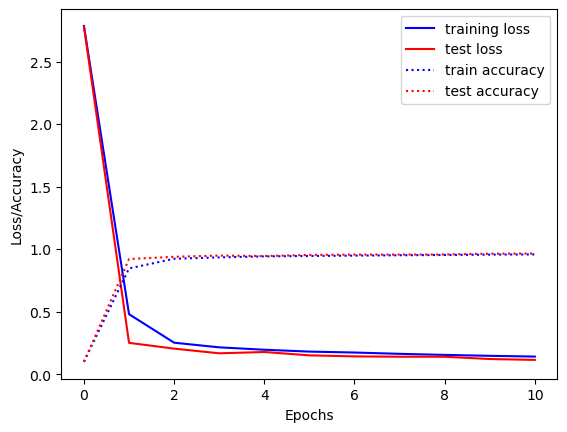

In [10]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 32 # from 256 to 32 units

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**

The runtime was faster with only 32 units per layer. We can also see that the training and test loss behave very similar. The accuracy on the test set reacht 96.4% in the end, which is a bit less than the 98.9% of the original model. We can assume that the smallest model with sufficient accuracy needs a number of units between 32 and 256.



### 2) Increasing batch size from 32 to 64

Pretraining, Loss: 3.1796703338623047, Accuracy: 0.09984674840085288, (Train)
Pretraining, Loss: 3.177255868911743, Accuracy: 0.10021894904458599, (Test)
Epoch: 1, Loss: 0.37648695707321167, Accuracy: 0.8839452292110874, (Train)
Epoch: 1, Loss: 0.19806008040905, Accuracy: 0.9412480010660981, (Test)
Epoch: 2, Loss: 0.16512629389762878, Accuracy: 0.9499766791044776, (Train)
Epoch: 2, Loss: 0.16904231905937195, Accuracy: 0.9475279850746269, (Test)
Epoch: 3, Loss: 0.12221655249595642, Accuracy: 0.9636693763326226, (Train)
Epoch: 3, Loss: 0.09133563935756683, Accuracy: 0.9730976812366737, (Test)
Epoch: 4, Loss: 0.09853710979223251, Accuracy: 0.9705157249466951, (Train)
Epoch: 4, Loss: 0.0823066458106041, Accuracy: 0.9750299840085288, (Test)
Epoch: 5, Loss: 0.0824863389134407, Accuracy: 0.9748467484008528, (Train)
Epoch: 5, Loss: 0.0665476843714714, Accuracy: 0.9802438699360341, (Test)
Epoch: 6, Loss: 0.0701051726937294, Accuracy: 0.9791111407249466, (Train)
Epoch: 6, Loss: 0.065865702927112

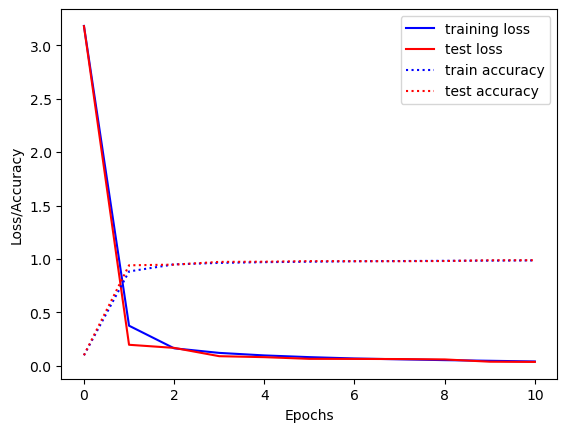

In [15]:
num_epochs = 10
learning_rate = 0.1
batch_size = 64 # from 32 to 64 units
n_unit = 256 

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**

There are only marginal differences in the training behaviour between using a batch size of 32 and 64. A batch size of 64 had a shorter runtime.


### 3) Increasing learning rate from 0.1 to 0.2

Pretraining, Loss: 2.6682448387145996, Accuracy: 0.11561666666666667, (Train)
Pretraining, Loss: 2.6616756916046143, Accuracy: 0.12000798722044728, (Test)
Epoch: 1, Loss: 1.3577320575714111, Accuracy: 0.5304333333333333, (Train)
Epoch: 1, Loss: 0.46854040026664734, Accuracy: 0.8643, (Test)
Epoch: 2, Loss: 0.4213390350341797, Accuracy: 0.8767666666666667, (Train)
Epoch: 2, Loss: 0.2616046071052551, Accuracy: 0.9194666666666667, (Test)
Epoch: 3, Loss: 0.3042044937610626, Accuracy: 0.9111666666666667, (Train)
Epoch: 3, Loss: 0.3936753571033478, Accuracy: 0.88135, (Test)
Epoch: 4, Loss: 0.26380297541618347, Accuracy: 0.9244666666666667, (Train)
Epoch: 4, Loss: 0.2139207124710083, Accuracy: 0.9371666666666667, (Test)
Epoch: 5, Loss: 0.23989181220531464, Accuracy: 0.931, (Train)
Epoch: 5, Loss: 0.18748049437999725, Accuracy: 0.9451333333333334, (Test)
Epoch: 6, Loss: 0.21610435843467712, Accuracy: 0.9376833333333333, (Train)
Epoch: 6, Loss: 0.22678613662719727, Accuracy: 0.933, (Test)
Epoch:

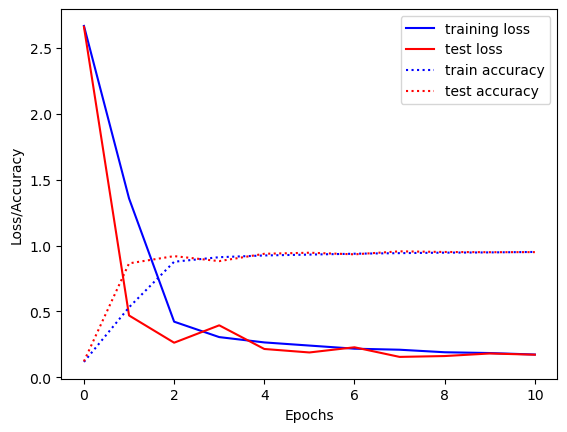

In [12]:
num_epochs = 10
learning_rate = 0.2  # from 0.1 to 0.2
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**

Higher learning rate causing fluctuation in the performance. Learning rate is the step size while finding the minimum loss in gradient descent. Higher learning rate means the model might skip the optimal value for the minimum loss, thus makes the model has a slower performance in reaching the convergence.

### 4) Reducing 2 layers to 1 hidden layer (256 neurons)

In [13]:
# Updating model to only 1 hidden layer

class MyModel(tf.keras.Model):
    # Define the layers of the model
    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        # self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # Forward pass
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        # x = self.dense2(x)
        x = self.out(x)
        return x

Pretraining, Loss: 2.6630349159240723, Accuracy: 0.06635, (Train)
Pretraining, Loss: 2.6548807621002197, Accuracy: 0.0683905750798722, (Test)
Epoch: 1, Loss: 0.3554953336715698, Accuracy: 0.89025, (Train)
Epoch: 1, Loss: 0.18948617577552795, Accuracy: 0.9413833333333333, (Test)
Epoch: 2, Loss: 0.1554025560617447, Accuracy: 0.9522166666666667, (Train)
Epoch: 2, Loss: 0.14853423833847046, Accuracy: 0.95285, (Test)
Epoch: 3, Loss: 0.11942625045776367, Accuracy: 0.96285, (Train)
Epoch: 3, Loss: 0.09006528556346893, Accuracy: 0.97225, (Test)
Epoch: 4, Loss: 0.09846498817205429, Accuracy: 0.96945, (Train)
Epoch: 4, Loss: 0.09031113237142563, Accuracy: 0.9708, (Test)
Epoch: 5, Loss: 0.08417206257581711, Accuracy: 0.9740166666666666, (Train)
Epoch: 5, Loss: 0.07431145757436752, Accuracy: 0.9764333333333334, (Test)
Epoch: 6, Loss: 0.0734935998916626, Accuracy: 0.9766, (Train)
Epoch: 6, Loss: 0.05788102746009827, Accuracy: 0.9809666666666667, (Test)
Epoch: 7, Loss: 0.06422767043113708, Accuracy:

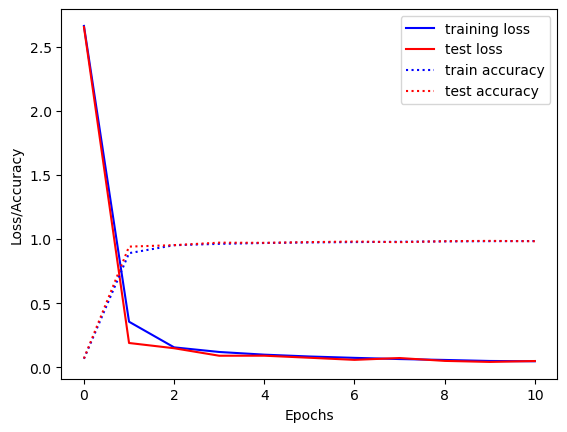

In [18]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 256 

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**
It seems like the model with only one layer delivers comparable results to the two-layer model. This could be because the 256 units have enough computing power to be able to account for the missing layer.



### 5) Using Adam as Optimizer


Pretraining, Loss: 2.705570936203003, Accuracy: 0.10475, (Train)
Pretraining, Loss: 2.718949317932129, Accuracy: 0.10373402555910544, (Test)
Epoch: 1, Loss: 0.2909010648727417, Accuracy: 0.9105333333333333, (Train)
Epoch: 1, Loss: 0.1435602307319641, Accuracy: 0.9574333333333334, (Test)
Epoch: 2, Loss: 0.15062570571899414, Accuracy: 0.9537166666666667, (Train)
Epoch: 2, Loss: 0.11510451883077621, Accuracy: 0.9643833333333334, (Test)
Epoch: 3, Loss: 0.11467228829860687, Accuracy: 0.9643333333333334, (Train)
Epoch: 3, Loss: 0.09305890649557114, Accuracy: 0.9706, (Test)
Epoch: 4, Loss: 0.09348765015602112, Accuracy: 0.9709, (Train)
Epoch: 4, Loss: 0.07552768290042877, Accuracy: 0.9760833333333333, (Test)
Epoch: 5, Loss: 0.08230994641780853, Accuracy: 0.9741, (Train)
Epoch: 5, Loss: 0.06715183705091476, Accuracy: 0.9785166666666667, (Test)
Epoch: 6, Loss: 0.0695369616150856, Accuracy: 0.9775, (Train)
Epoch: 6, Loss: 0.05432926490902901, Accuracy: 0.9826333333333334, (Test)
Epoch: 7, Loss: 

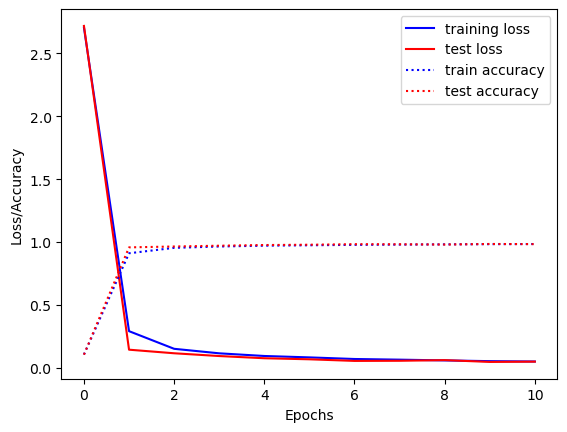

In [20]:
num_epochs = 10
learning_rate = 0.1 # Adam uses a different learning rate by default
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.Adam(),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**
The runtime is longer when using Adam. The test accuracy of Adam after training is almost similar to the one of our first model. But the accuracy after one epoch is better when using Adam. 